In [121]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import pandas as pd

In [122]:
stocks = pd.read_csv('../data_challenge_stock_prices.csv')
stocks.head()
indices = pd.read_csv('../data_challenge_index_prices.csv')
indices.head()
print(len(stocks))
print(len(indices))
stock_returns = stocks.pct_change().dropna()*10000
index_returns = indices.pct_change().dropna() * 10000
stock_returns_T =stock_returns.T
index_returns_T =index_returns.T


200000
200000


In [123]:
def zscore_normalize_features(X):
    """
    computes  X, zcore normalized by column
    
    Args:
      X (ndarray (m,n))     : input data, m examples, n features
      
    Returns:
      X_norm (ndarray (m,n)): input normalized by column
      mu (ndarray (n,))     : mean of each feature
      sigma (ndarray (n,))  : standard deviation of each feature
    """
    # find the mean of each column/feature
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu,sigma)

In [124]:
norm_stock_returns, X_mu, X_sigma = zscore_normalize_features(stock_returns)
norm_index_returns, X_mu, X_sigma = zscore_normalize_features(index_returns)

100%|██████████| 19/19 [01:15<00:00,  3.95s/it]


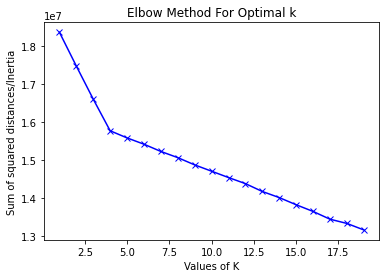

In [5]:
Sum_of_squared_distances = []
K = range(1,20)

for num_clusters in tqdm(K) :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(norm_stock_returns.T)
 Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [125]:
norm_stock_returns_T = norm_stock_returns.T
M=4
kmeans = KMeans(n_clusters=4)
kmeans.fit(norm_stock_returns_T)
clusters = kmeans.labels_
print(clusters)

[0 0 2 2 0 1 2 2 3 2 0 0 3 1 0 1 2 2 0 2 0 0 0 2 1 0 0 3 2 3 3 1 2 2 1 1 3
 1 0 0 3 3 2 0 3 0 3 2 1 0 3 2 3 2 0 3 1 3 2 3 2 1 1 2 1 1 2 0 1 3 1 3 2 3
 3 0 1 3 0 0 3 2 0 1 3 1 1 2 0 1 0 2 3 1 1 1 3 1 2 3]


In [126]:
sectors = {i: [] for i in range(M)}
for stock, sector in zip(norm_stock_returns.columns, clusters):
    sectors[sector].append(stock)

In [127]:
for i in range(len(sectors)):
    print(len(sectors[i]))

# print(4*2**25)

25
25
25
25


In [47]:
# MLP regressor

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

# Create an instance of the MLPRegressor class
# model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', alpha=0.01, max_iter=200)

# Train the model on the training data
# model.fit(X_train, y_train)

# Make predictions on the test data
# y_pred = model.predict(X_test)

# Compute the mean absolute error
# mae = mean_absolute_error(y_test, y_pred)
# print("Mean Absolute Error: ", mae)

index_predictions = pd.DataFrame()

for index in index_returns.columns:
    
    best_score = -1
    best_sector = None
    best_preds = None
    
    for sector in sectors:
        X = stock_returns[sectors[sector]]
        y = index_returns[index]
        # Scale the input features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X)

        # print(type(y))

        # Create an instance of the MLPRegressor class
        model = MLPRegressor(hidden_layer_sizes=(15,5), activation='relu', solver='adam', alpha=0.01, max_iter=500)

        # Train the model on the training data
        model.fit(X_train, y)

        # Make predictions
        preds = model.predict(X_train)

        score = np.corrcoef(y,preds)[0,1]

        if score > best_score:
            best_score = score
            best_sector = sector
            best_preds = preds
            # print(score)

    if best_score >= 0.4:  # 40% predictive correlation
        print(f"Index {index} belongs to sector {best_sector} with correlation {best_score}")
        index_predictions[index] = best_preds
    else:
        print(f"Index {index} could not be solved with max correlation {best_score}")



Index 0 belongs to sector 0 with correlation 0.4491892421918561
Index 1 belongs to sector 1 with correlation 0.41689679891886233
Index 2 belongs to sector 0 with correlation 0.6080348388645738
Index 3 belongs to sector 3 with correlation 0.4493291855252194
Index 4 belongs to sector 2 with correlation 0.45118098353857844
Index 5 belongs to sector 1 with correlation 0.5930012430217189
Index 6 belongs to sector 3 with correlation 0.4483911874780483
Index 7 could not be solved with max correlation 0.39900047783350356
Index 8 belongs to sector 3 with correlation 0.4065356104361991
Index 9 belongs to sector 2 with correlation 0.4505966571014396
Index 10 belongs to sector 1 with correlation 0.44898020711260517
Index 11 belongs to sector 0 with correlation 0.4474516716986008
Index 12 belongs to sector 2 with correlation 0.44683401619679664
Index 13 belongs to sector 3 with correlation 0.4501566351701191
Index 14 belongs to sector 2 with correlation 0.5969951378854911


In [48]:
covariance_matrix = index_predictions.cov()
print(covariance_matrix)

           0         1         2         3         4         5         6  \
0   1.552294  0.053637 -0.198452 -0.146502  0.312102 -0.042221  0.289724   
1   0.053637  0.112732 -0.006436 -0.030563  0.056624 -0.037005  0.060395   
2  -0.198452 -0.006436  0.447218  0.015333 -0.036658  0.005984 -0.028497   
3  -0.146502 -0.030563  0.015333  2.390012 -0.125128  0.023146 -0.691857   
4   0.312102  0.056624 -0.036658 -0.125128  1.629259 -0.046170  0.268379   
5  -0.042221 -0.037005  0.005984  0.023146 -0.046170  0.444953 -0.046470   
6   0.289724  0.060395 -0.028497 -0.691857  0.268379 -0.046470  1.510790   
8   0.054364  0.011745 -0.004950 -0.139656  0.051481 -0.009212  0.287305   
9  -0.177693 -0.038730  0.018408  0.082691 -0.773980  0.030717 -0.164231   
10 -0.093503 -0.153240  0.010231  0.071949 -0.100323  0.099966 -0.131304   
11  0.076545  0.003580  0.101679 -0.021106  0.021292  0.002519  0.016412   
12  0.005119  0.000718  0.001901 -0.002908  0.009571  0.001627  0.003274   
13 -0.000995

In [16]:
covariance_matrix = index_predictions.cov()
print(covariance_matrix)

           0         1         2         3         4         5         6  \
0   0.216988  0.024321 -0.067169 -0.017896  0.039923 -0.012740  0.038910   
1   0.024321  0.168380 -0.006933 -0.011801  0.023328 -0.036732  0.026167   
2  -0.067169 -0.006933  0.389192  0.004665 -0.011477  0.003778 -0.008204   
3  -0.017896 -0.011801  0.004665  0.215825 -0.013842  0.005821 -0.081416   
4   0.039923  0.023328 -0.011477 -0.013842  0.189640 -0.012581  0.032873   
5  -0.012740 -0.036732  0.003778  0.005821 -0.012581  0.335826 -0.013573   
6   0.038910  0.026167 -0.008204 -0.081416  0.032873 -0.013573  0.193811   
7   0.147830  0.016884 -0.037194 -0.011631  0.028083 -0.008391  0.027539   
9  -0.016886 -0.012190  0.003984  0.006838 -0.065192  0.006508 -0.015182   
10 -0.009026 -0.048886  0.002099  0.006098 -0.008873  0.022548 -0.012333   
11  0.006513  0.000610  0.057052 -0.002418  0.001480  0.001381  0.000666   
12  0.001302  0.000667  0.000993 -0.000688  0.000482  0.000500  0.000927   
13  0.003200

In [49]:
print(np.diag(covariance_matrix))
variances = pd.DataFrame(np.diag(covariance_matrix),index=index_predictions.columns)
print(variances)
print(variances.columns)

[1.55229386 0.11273153 0.44721776 2.39001198 1.62925947 0.44495321
 1.51079023 0.09620662 2.55128262 2.6434034  0.75115275 0.71823061
 0.69342853 0.43972415]
           0
0   1.552294
1   0.112732
2   0.447218
3   2.390012
4   1.629259
5   0.444953
6   1.510790
8   0.096207
9   2.551283
10  2.643403
11  0.751153
12  0.718231
13  0.693429
14  0.439724
RangeIndex(start=0, stop=1, step=1)


In [46]:
print(np.diag(covariance_matrix))
variances = pd.DataFrame(np.diag(covariance_matrix),index=index_predictions.columns)
print(variances)
print(variances.columns)

[0.21698843 0.16838004 0.38919181 0.21582513 0.18964034 0.33582588
 0.19381133 0.17522328 0.19491299 0.20663696 0.19616497 0.20415521
 0.18849696 0.35996872]
           0
0   0.216988
1   0.168380
2   0.389192
3   0.215825
4   0.189640
5   0.335826
6   0.193811
7   0.175223
9   0.194913
10  0.206637
11  0.196165
12  0.204155
13  0.188497
14  0.359969
RangeIndex(start=0, stop=1, step=1)


In [104]:
from scipy.optimize import minimize

# Extract the actual stock prices and predicted stock returns for each stock

index_list = list(range(15))
index_list.remove(7)
index_list = [str(i) for i in index_list]

actual_prices = index_returns.loc[ : , index_list ]
predicted_returns = index_predictions

# print(actual_prices.describe())
# print(predicted_returns.describe())

# Load the variance data for each stock
variances = pd.DataFrame(np.diag(covariance_matrix),index=index_list)

def objective(weights, predicted_returns, variances):
    """
    Compute the objective function for mean-variance optimization.
    """
    mean_return = np.dot(weights.T, predicted_returns.mean(axis=0))
    print(mean_return.shape)
    variance = np.dot(weights.T, np.dot(np.diag(variances), weights))
    print(variance.shape)
    return -mean_return / np.sqrt(variance)

def constraint(weights):
    """
    Constraint function to ensure long and short positions net out completely.
    """
    return np.sum(np.abs(weights)) - np.sum(weights)

# Set up the optimization problem
initial_weights = np.zeros(14)
constraints = ({'type': 'eq', 'fun': constraint})
bounds = [(-1, 1) for i in range(14)]

# Solve for the optimal portfolio allocation
result = minimize(objective, initial_weights, args=(predicted_returns, variances), constraints=constraints, bounds=bounds)
weights = result.x

# Compute the allocation for each stock
positive_weights = weights[weights > 0]
negative_weights = weights[weights < 0]
total_weight = np.sum(np.abs(negative_weights))
positive_allocation = positive_weights / np.sum(positive_weights)
negative_allocation = np.abs(negative_weights) / total_weight
allocation = np.zeros(14)
allocation[weights > 0] = positive_allocation
allocation[weights < 0] = -negative_allocation

# Compute the position for each stock based on the allocation
position = allocation * 1

# Print the allocation and position for each stock
for i in range(14):
    print(f"Stock {i+1}: Allocation={allocation[i]:.2f}, Position={position[i]:.2f}")

# In this example, we again load the actual stock prices and predicted stock returns from a CSV file and the variance data from a numpy array. We define the objective function and constraint function for mean-variance optimization. However, this time we define the constraint function differently to ensure that the long and short positions net out completely.

# We set up the optimization problem and solve for the optimal portfolio allocation. However, since we want the long and short positions to net out completely, we need to adjust the allocation accordingly. We first separate the positive and negative weights, and compute the allocation separately for each. We then adjust the allocation for the negative weights to ensure that they net out completely with the positive weights. Finally, we compute the position for each stock based on the allocation.

# Note that in this example, we assume that we can only long or short a maximum of 1 dollar for each timestep. If we want to trade more than 1 dollar, we need to adjust the position accordingly. We also assume that the variance data is known and fixed, which may not be the case in a real-world scenario.

# Sure, here's an example of how to compute the mean, standard deviation, and Sharpe ratio of the trading strategy in Python:

# Compute the returns for the trading strategy
returns = np.dot(allocation, predicted_returns.T)

# Compute the mean, standard deviation, and Sharpe ratio of the returns
mean_return = np.mean(returns)
stdev_return = np.std(returns)
sharpe_ratio = mean_return / stdev_return

# Print the results
print(f"Mean Return: {mean_return:.4f}")
print(f"Standard Deviation: {stdev_return:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
# In this example, we first compute the returns for the trading strategy by taking the dot product of the allocation and predicted returns. We then compute the mean, standard deviation, and Sharpe ratio of the returns using numpy functions. Finally, we print the results.

# Note that the assumptions in the above execution scheme include:

# We assume that the predicted stock returns are accurate and reliable. In reality, there may be errors or uncertainties in the predictions that could affect the performance of the trading strategy.
# We assume that the variance data is known and fixed. In reality, the variances of the stock returns may change over time, which could affect the performance of the trading strategy.
# We assume that we can only long or short a maximum of 1 dollar for each timestep. In reality, there may be constraints on the maximum position size or other trading rules that could affect the performance of the trading strategy.
# We assume that the optimization problem is well-posed and can be solved accurately. In reality, the optimization problem may be ill-posed or difficult to solve, which could affect the performance of the trading strategy.
# We assume that the past performance of the trading strategy is a good indicator of its future performance. In reality, the market conditions and other factors may change over time, which could affect the performance of the trading strategy.

ValueError: shapes (14,) and (15,) not aligned: 14 (dim 0) != 15 (dim 0)

In [136]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Extract the actual stock prices and predicted stock returns for each stock
actual_prices = index_returns
predicted_returns = index_predictions
predicted_returns['7'] = index_returns['7']

# print(predicted_returns.mean(axis=0).to_numpy())
# print(initial_weights)

# Load the variance data for each stock
variances = np.array([0.1, 0.2, 0.15, 0.25, 0.12, 0.18, 0.08, 0.1, 0.2, 0.15, 0.25, 0.12, 0.18, 0.08, 0.1])

def objective(weights, predicted_returns, variances):
    """
    Compute the objective function for mean-variance optimization.
    """
    mean_return = np.dot(weights.T, predicted_returns.mean(axis=0).to_numpy())
    variance = np.dot(weights.T, variances*weights)
    return -mean_return / np.sqrt(variance)

def constraint(weights):
    """
    Constraint function to ensure long and short positions net out completely.
    """
    return np.sum(np.abs(weights)) - np.sum(weights)

# Set up the optimization problem
initial_weights = np.random.rand(15,1).reshape(15)
constraints = ({'type': 'eq', 'fun': constraint})
bounds = [(-1, 1) for i in range(15)]

# Solve for the optimal portfolio allocation
result = minimize(objective, initial_weights, args=(predicted_returns, variances), constraints=constraints, bounds=bounds)
# print(result)
weights = result.x
print(weights.shape)

# Compute the allocation for each stock
positive_weights = weights[weights > 0]
negative_weights = weights[weights < 0]
total_weight = np.sum(np.abs(negative_weights))
positive_allocation = positive_weights / np.sum(positive_weights)
negative_allocation = np.abs(negative_weights) / total_weight
allocation = np.zeros(15)
allocation[weights > 0] = positive_allocation
allocation[weights < 0] = -negative_allocation

# Compute the position for each stock based on the allocation
position = allocation * 1

# Print the allocation and position for each stock
for i in range(15):
    print(f"Stock {i+1}: Allocation={allocation[i]:.2f}, Position={position[i]:.2f}")

# print(returns.shape)
# print(predicted_returns.T.shape)
# Compute the returns for the trading strategy
returns = np.dot(allocation, predicted_returns.T)
print(returns)

# Compute the mean, standard deviation, and Sharpe ratio of the returns
mean_return = np.mean(returns)
stdev_return = np.std(returns)
sharpe_ratio = mean_return / stdev_return

# Print the results
print(f"Mean Return: {mean_return:.4f}")
print(f"Standard Deviation: {stdev_return:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")


(15,)
Stock 1: Allocation=0.06, Position=0.06
Stock 2: Allocation=0.13, Position=0.13
Stock 3: Allocation=0.06, Position=0.06
Stock 4: Allocation=0.13, Position=0.13
Stock 5: Allocation=0.10, Position=0.10
Stock 6: Allocation=0.01, Position=0.01
Stock 7: Allocation=0.01, Position=0.01
Stock 8: Allocation=0.08, Position=0.08
Stock 9: Allocation=0.01, Position=0.01
Stock 10: Allocation=0.13, Position=0.13
Stock 11: Allocation=0.06, Position=0.06
Stock 12: Allocation=0.11, Position=0.11
Stock 13: Allocation=0.03, Position=0.03
Stock 14: Allocation=0.04, Position=0.04
Stock 15: Allocation=0.04, Position=0.04
[        nan -0.24341593  0.12322497 ... -0.18650551 -0.15469033
  0.19121042]
Mean Return: nan
Standard Deviation: nan
Sharpe Ratio: nan


In [147]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

index_list = list(range(15))
index_list.remove(7)
index_list = [str(i) for i in index_list]

# Extract the actual stock prices and predicted stock returns for each stock
actual_prices = index_returns
print(actual_prices)
predicted_returns = index_predictions
print(predicted_returns)
print(index_list)




               0         1         2         3         4         5         6  \
1      -3.813718 -0.482901  0.574910  2.270976  0.776114  0.575093  5.552967   
2       2.162276 -0.404774  0.365852 -1.350740  0.882502  0.365968  1.184262   
3       1.124595  0.006841 -0.522646  0.106836  1.289452  1.672997 -4.614627   
4       4.613970 -0.632970 -0.522646 -2.304943 -3.415103 -0.522812 -6.014006   
5       0.518727 -0.585448  0.365852  2.273576  0.161257 -0.522812  2.528405   
...          ...       ...       ...       ...       ...       ...       ...   
199995  3.088871  0.751899 -1.045291 -3.333527 -0.917390 -1.672997  4.382245   
199996 -0.767949 -1.533943  0.365852  1.785761  0.396643 -1.097904 -1.898434   
199997 -1.047323  0.236460 -1.097556 -0.484082 -3.229254  0.575093  2.289020   
199998 -1.423336 -0.571317 -1.672466 -6.772663 -2.447138  1.672997 -0.750087   
199999 -5.267382 -0.874139  1.672466  0.210809 -3.950857 -1.672997  1.299305   

               8         9        10   

In [103]:
a = np.array([2,3,4])
b= np.array([2,3,4])
print(np.dot(a.T,b))

29


In [94]:
# preds = model.predict(X)
# score = pearsonr(y,preds)
# print(score)

for index in index_returns.columns:
    index = '2'
    preds = index_predictions[index]
    y = norm_index_returns[index]
    df = pd.DataFrame()
    df['preds'] = preds
    df['y'] = list(y)
    print(df)
    break


           preds         y
0      -0.047379  0.522361
1       0.329483  0.333824
2       0.029004 -0.467456
3       0.208019 -0.467456
4      -0.025191  0.333824
...          ...       ...
199994 -0.403523 -0.938797
199995  0.210028  0.333824
199996 -0.437382 -0.985931
199997 -0.084600 -1.504406
199998  0.412650  1.512177

[199999 rows x 2 columns]


In [52]:
# import tensorflow as tf
# from tensorflow import keras
# model = tf.keras.models.Sequential()

# model = keras.Sequential([
#   keras.layers.Dense(units=15, activation='relu', input_shape=(25,)),
#   keras.layers.Dense(units=5, activation='relu'),
#   keras.layers.Dense(units=1, activation='linear')
# ])

# model.add(tf.keras.layers.)
# # Building the input and the hidden layers
# model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
# model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
# # Building the output layer
# model.add(tf.keras.layers.Dense(1,activation = 'linear'))

# model.compile(optimizer="adam", loss="MeanSquaredError", metrics=["accuracy",'mae'])

In [48]:
print(len(X.columns))

25


In [83]:
from quadprog import solve_qp as quadprog

# vector of stock prices
stock_prices = index_returns.loc[: , index_list]

# matrix of index predictions
index_predictions = index_predictions

# covariance matrix
covariance = covariance_matrix

# number of stocks and indices
num_stocks = stock_prices.shape[1]
num_indices = index_predictions.shape[1]

# initialize portfolio weights to zero
weights = np.zeros((num_indices, num_stocks))

# iterate over each time step
for t in range(1, len(stock_prices)):
    # calculate the predicted returns and covariance for this time step
    pred_returns = index_predictions.loc[[t], :]
    cov = covariance

    # use quadratic programming to find the optimal weights
    P = cov
    q = np.zeros(num_indices)
    G = np.vstack([np.eye(num_indices), -np.eye(num_indices)])
    h = np.ones(num_indices)
    A = np.ones(num_indices)
    b = np.array([1.0])
    print(type(quadprog(P, q, G, h, A, b)))
    weights[t, :], _, _ = quadprog(P, q, G, h, A, b)

    # normalize the weights to ensure a maximum long/short position of $1
    not_zero = weights[t, :] != 0
    weights[t, not_zero] = weights[t, not_zero] / np.sum(np.abs(weights[t, not_zero]))

    # calculate the trades for this time step
    trades = weights[t, :] * stock_prices[t - 1, :]

    # ensure that the long-short positions net out completely
    trades = trades - np.mean(trades)

    # update the portfolio value for this time step
    portfolio_value = np.sum(trades)
    
mean_return = np.mean(np.sum(weights * index_predictions, axis=1))
std_dev = np.std(np.sum(weights * index_predictions, axis=1))
sharpe_ratio = mean_return/std_dev

TypeError: a bytes-like object is required, not 'DataFrame'

In [9]:
# previous method

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import ppscore as pps

# Choose a regressor: LinearRegression, Lasso, or Ridge

regressor = LinearRegression(fit_intercept=True)
index_predictions = pd.DataFrame()

for index in index_returns.columns:
    
    best_score = -1
    best_sector = None
    best_preds = None
    
    for sector in sectors:
        X = norm_stock_returns[sectors[sector]]
        y = norm_index_returns[index]
        # print(type(y))

        model = regressor.fit(X.loc[0:10000,:], y[:10000])
        preds = model.predict(X)

        df = pd.DataFrame(columns=['y','preds'])
        df['y'] = y
        df['preds'] = preds

        score = pearsonr(y, preds)
        # score = np.correlation(preds,y)
        score = score[0]
        # score = r2_score(y, preds)
        # score = score**0.5
        # print(score)

        if score > best_score:
            best_score = score
            best_sector = sector
            best_preds = preds
            # print(score)

    if best_score >= 0.4:  # 40% predictive correlation
        print(f"Index {index} belongs to sector {best_sector}")
        index_predictions[index] = best_preds
        print(best_score)
    else:
        print(f"Index {index} could not be solved")
        print(best_score)

# Compute the covariance matrix of the index predictions
covariance_matrix = index_predictions.cov()

Index 0 belongs to sector 0
0.44327480635250455
Index 1 could not be solved
0.31119206523274157
Index 2 could not be solved
0.20610570135392597
Index 3 could not be solved
0.34199729775396315
Index 4 belongs to sector 2
0.44645989420224036
Index 5 could not be solved
0.21579737697124057
Index 6 belongs to sector 3
0.44380184920735266
Index 7 could not be solved
0.3018985083553388
Index 8 could not be solved
0.304073300302279
Index 9 could not be solved
0.34616522003027295
Index 10 could not be solved
0.3387910378670748
Index 11 could not be solved
0.002980653833538585
Index 12 could not be solved
0.008467730813550296
Index 13 could not be solved
0.005856225906110284
Index 14 could not be solved
0.2077396150139465
